In [54]:

# Jupyterでmatplotlibを使用する宣言と、使用するライブラリの定義
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from matplotlib import animation
from IPython.display import display
from IPython.display import HTML
 
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
 
    def animate(i):
        patch.set_data(frames[i])
 
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
 
    anim.save('movie_cartpole.mp4')  # 追記：動画の保存です
    #display(display_animation(anim, default_mode='loop'))
    #HTML(anim.to_html5_video())
    return anim

続いて、今回使用する定数を以下のように定義します。MAX_STEPSは1試行の最大ステップ数です。CartPole-v0の場合は200step立ち続ければゲーム攻略となるので200としています。NUM_EPISODESは最大の試行回数です。今回は1000と設定し、この試行数以内にゲームの攻略を目指します。

In [56]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
 
NUM_DIZITIZED = 6  # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数
 
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 1000  # 最大試行回数

In [57]:
# CartPoleをランダムに動かす
frames = []
env = gym.make('CartPole-v0', render_mode="rgb_array")
observation = env.reset()
print(observation)
num = env.observation_space.shape[0]
print(num)
# observation に格納されるのはタプルなので、コード修正した

(array([ 0.03915382, -0.00473583,  0.02598812, -0.04450833], dtype=float32), {})
4


c:\Users\ikemix\anaconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


次にAgentクラスを定義します。Agentクラスはコンストラクタ（init）でCartPoleの状態変数の数と行動の種類数を格納します。また自身の頭脳となるBrainクラスを生成します。さきほど説明した通り、Q関数の更新と行動の決定をBrainクラスを通じて実行するメソッドを持ちます。

In [58]:

# CartPoleで動くエージェントクラスです、棒付き台車そのものになります
class Agent:
    def __init__(self, num_states, num_actions):
        # 課題の状態と行動の数を設定
        self.num_states = num_states     # CartPoleは状態数4を取得
        self.num_actions = num_actions        # CartPoleの行動（右に左に押す）の2を取得
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための脳を生成
 
    def update_q_function(self, observation, action, reward, observation_next):
        # Q関数の更新
        self.brain.update_Qtable(observation, action, reward, observation_next)
 
    def get_action(self, observation, step):
        # 行動の決定
        action = self.brain.decide_action(observation, step)
        return action

次にAgentが持つ頭脳となるクラスBrainを定義します。今回はQ学習を実装しています。少し長くて難しそうですが、やっていることは単純です。

関数binsとdigitize_stateを用いて、4変数の連続状態を1296通りの離散値へと変換しています。関数binsでnp.linspaceのあとに[1:-1]がついているのは、離散化する際に端を-InfとInfに設定するためです。関数digitize_stateにおいて、pole_angleを-0.5から0.5で離散化しているのは、この変数がプログラム内では[radian]で表されているからです。0.5[radian] = 約29[°]となります。関数digitize_stateのreturnの部分は一見難しそうですが、離散化された状態をNUM_DIZITIZED=6の場合には6進数で表現しています。例えば、　カート位置, カート速度, 棒の角度, 棒の角速度）＝（1, 2, 3, 4）　だった場合には、

1 ∗ 60 + 2 ∗ 61 + 3 ∗ 62 + 4 ∗ 63 = 985

となり、状態985と定義されます。

Qテーブルの更新方法は迷路課題のときと同様です。行動の決定は試行数が少ないときは探索行動が多くなるようにε-greedy法としています。この部分の実装には引用[2]も参考にさせていただきました。

In [59]:

# エージェントが持つ脳となるクラスです、Q学習を実行します
class Brain:
 
    def __init__(self, num_states, num_actions):
        self.num_states = num_states  # CartPoleは状態数4を取得
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
        # 状態を分割数^（4変数）にデジタル変換したQ関数（表）を作成
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**self.num_states, self.num_actions))
 
 
    def bins(self, clip_min, clip_max, num):
        #観測した状態（連続値）を離散値にデジタル変換する
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
 
    def digitize_state(self, observation):
        # 観測したobservation状態を、離散値に変換する
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
        np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
        np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])
 
    def update_Qtable(self, observation, action, reward, observation_next):
        # QテーブルをQ学習により更新
        # 観測を離散化
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
 
    def decide_action(self, observation, episode):
        # ε-greedy法で徐々に最適行動のみを採用する
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
 
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions) # 0,1の行動をランダムに返す
        return action

最後のクラスであるEnvironmentを定義します。今回は10回連続で195step以上立ち続ければ強化学習成功とし、動画を保存のためにもう1回実行してしています。self.env = gym.make(ENV)で、実施する課題を設定しています。self.env.observation_space.shape[0]は課題が持つ状態変数の数を示します。self.env.action_space.nは課題が持つ行動の数を示します。

OpenAI Gymを実行する際に、各試行の最初に以下の命令observation = self.env.reset()を実行する必要があります。observationには状態を表す変数の値が格納されます。

observation_next, reward_notuse, done, info_notuse = self.env.step(action)　は、actionを実行するメソッドです。その結果、実行後の次のステップでの状態observation_nextと、元々CartPole-v0で決められているルールでの報酬、実行終了フラグであるdone、その他情報のinfoが出力されます。doneは200step経過するか、棒が20.9度以上傾いたり、カート位置が±2.4の範囲外まで移動するとTrueとなります。今回はこの関数で出力される報酬と情報は使用しないので、notuseを記載しています。

episode_finalは、10試行連続で成功した場合にTrueとなるフラグです。episode_finalがTrueの試行では各stepでの画像をframesに格納していき、最後に動画を保存・再生します。

In [60]:

# CartPoleを実行する環境のクラスです
class Environment:
 
    def __init__(self):
        self.env = gym.make(ENV, render_mode="rgb_array") # 実行する課題を設定
        self.env.reset()
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(self.num_states, self.num_actions)  # 環境内で行動するAgentを生成
 
    def run(self):
        # 実行
 
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
 
 
        for episode in range(NUM_EPISODES):
        # 試行数分繰り返す
            observation = self.env.reset()[0]  # 環境の初期化
            episode_reward = 0  # エピソードでの報酬
 
            # 1エピソードのループ
            for step in range(MAX_STEPS):
 
                if episode_final is True:
                    # framesに各時刻の画像を追加していく
                    frames.append(self.env.render())
 
                action = self.agent.get_action(observation, episode)  # 行動を求める
 
                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                #observation_next, reward_notuse, done, info_notuse = self.env.step(action)
                observation_next, reward_notuse, done, trancated, info_notuse = self.env.step(action)
 
                # 報酬を与える
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    if step < 195:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        self.complete_episodes = 0
                    else:
                        reward = 1  # 立ったまま終了時は報酬1を与える
                        self.complete_episodes = self.complete_episodes + 1  # 連続記録を更新
                else:
                    reward = 0
 
                episode_reward += reward  # 報酬を追加
 
                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_q_function(
                    observation, action, reward, observation_next)
 
                # 観測の更新
                observation = observation_next
 
                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step+1))
                    break
 
            if episode_final is True:
                # 動画の保存と描画
                print('10回連続成功')
                self.anim = display_frames_as_gif(frames)
                #HTML(self.anim.to_html5_video())
                break
 
            if self.complete_episodes >= 10:
                print('10回連続成功')
                frames = []
                episode_final = True  # 次の試行を描画を行う最終試行とする


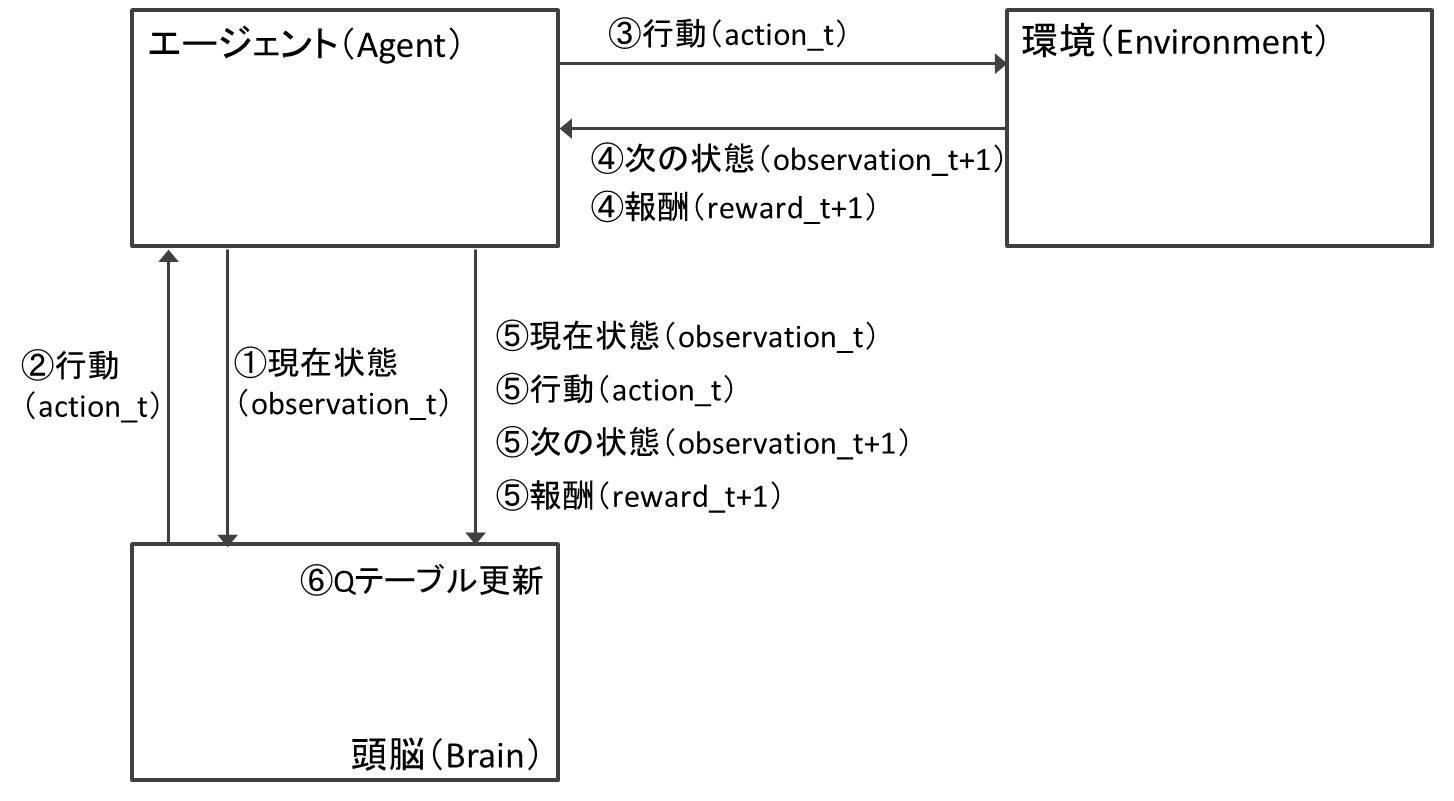

In [61]:
# pillowをインポート
from PIL import Image

# 画像パス
filename = "./cartpole_class.jfif"

# Pillowで開く
im = Image.open(filename)

# 表示
im

In [62]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()

HTML(cartpole_env.anim.to_html5_video())

c:\Users\ikemix\anaconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 Episode: Finished after 14 time steps
1 Episode: Finished after 71 time steps
2 Episode: Finished after 27 time steps
3 Episode: Finished after 37 time steps
4 Episode: Finished after 9 time steps
5 Episode: Finished after 12 time steps
6 Episode: Finished after 51 time steps
7 Episode: Finished after 17 time steps
8 Episode: Finished after 31 time steps
9 Episode: Finished after 13 time steps
10 Episode: Finished after 46 time steps
11 Episode: Finished after 42 time steps
12 Episode: Finished after 38 time steps
13 Episode: Finished after 52 time steps
14 Episode: Finished after 35 time steps
15 Episode: Finished after 49 time steps
16 Episode: Finished after 30 time steps
17 Episode: Finished after 19 time steps
18 Episode: Finished after 171 time steps
19 Episode: Finished after 28 time steps
20 Episode: Finished after 31 time steps
21 Episode: Finished after 28 time steps
22 Episode: Finished after 33 time steps
23 Episode: Finished after 21 time steps
24 Episode: Finished after

AttributeError: 'int' object has no attribute 'to_html5_video'